In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
np.random.seed(1)
x1 =  np.random.uniform(6,size = 100) # x1 between [0,6]
x1 = np.around(x1, 2)
x2 =  np.random.uniform(6,size = 100) # x2 between [0,6]
x2 = np.around(x2, 2)
x3 =  np.random.uniform(-6, 0 ,size = 100) # x3 between [-6,0]
x3 = np.around(x3, 2)
x4 =  np.random.uniform(-6, 0, size = 100) # x4 between [-6,0]
x4 = np.around(x4, 2)

dataset_0_0 = pd.DataFrame({'x1': x1[ : 50], 'x2': x2[ : 50], 'y': [0]*50})
# print(dataset_0_0)
dataset_0_1 = pd.DataFrame({'x1': x1[50 : ], 'x2': x4[ : 50], 'y': [1]*50})
dataset_1_0 = pd.DataFrame({'x1': x3[ : 50], 'x2': x2[50 : ], 'y': [1]*50})
dataset_1_1 = pd.DataFrame({'x1': x3[50 : ], 'x2': x4[50 : ], 'y': [0]*50})

train_data = pd.concat([dataset_0_0, dataset_0_1, dataset_1_0, dataset_1_1])
# print(train_data)
# df = pd.DataFrame(train_data)
# print(df.to_string())

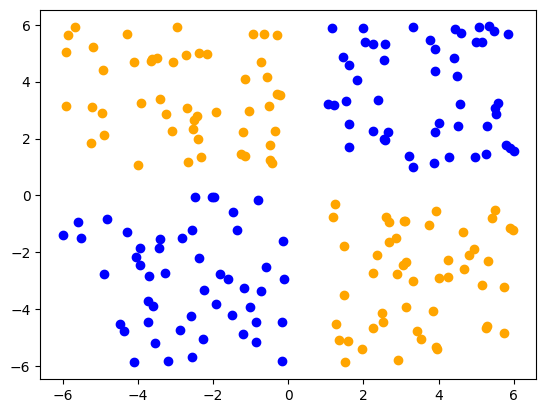

In [3]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(train_data['x1'][train_data['y'] == 0], train_data['x2'][train_data['y'] == 0], color = 'blue')
ax.scatter(train_data['x1'][train_data['y'] == 1], train_data['x2'][train_data['y'] == 1], color = 'orange')

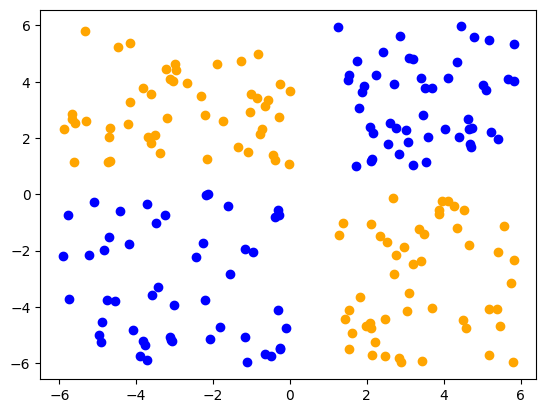

In [4]:
np.random.seed(20)
# test set
x1 =  np.random.uniform(6,size = 100) # x1 between [0,6]
x1 = np.around(x1, 2)
x2 =  np.random.uniform(6,size = 100) # x2 between [0,6]
x2 = np.around(x2, 2)
x3 =  np.random.uniform(-6, 0 ,size = 100) # x3 between [-6,0]
x3 = np.around(x3, 2)
x4 =  np.random.uniform(-6, 0, size = 100) # x4 between [-6,0]
x4 = np.around(x4, 2)

dataset_0_0 = pd.DataFrame({'x1': x1[ : 50], 'x2': x2[ : 50], 'y1': [0]*50})
# dataset_0_0
dataset_0_1 = pd.DataFrame({'x1': x1[50 : ], 'x2': x4[ : 50], 'y1': [1]*50})
# dataset_0_1
dataset_1_0 = pd.DataFrame({'x1': x3[ : 50], 'x2': x2[50 : ], 'y1': [1]*50})
# dataset_1_0
dataset_1_1 = pd.DataFrame({'x1': x3[50 : ], 'x2': x4[50 : ], 'y1': [0]*50})
# dataset_1_1
test_data = pd.concat([dataset_0_0, dataset_0_1, dataset_1_0, dataset_1_1])


fig = plt.figure()
ax = plt.axes()
ax.scatter(test_data['x1'][test_data['y1'] == 0], test_data['x2'][test_data['y1'] == 0], color = 'blue')
ax.scatter(test_data['x1'][test_data['y1'] == 1], test_data['x2'][test_data['y1'] == 1], color = 'orange');

In [5]:
# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [6]:
train_data = train_data.sample(frac=1).reset_index(drop=True)
# print(train_data)
test_data = test_data.sample(frac=1).reset_index(drop=True)
X_train = train_data[['x1', 'x2']].values.astype(np.float32)
y_train = train_data['y'].values.reshape(-1, 1).astype(np.float32)
# print(y_train)
X_test = test_data[['x1', 'x2']].values.astype(np.float32)
y_test = test_data['y1'].values.reshape(-1, 1).astype(np.float32)

# Create DataLoader
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)

In [7]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()



    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [8]:
# Initialize the model, loss function, and optimizer
model = MLP(input_size=2, hidden_size=4)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)
model

MLP(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# baseline accuracy and loss
accuracy, train_loss = 0, 0
for inputs, labels in train_loader:
    outputs = model(inputs)
    output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
    accuracy += torch.sum(output_labels == labels)
    loss = criterion(outputs, labels)
    train_loss += loss.item()

print(f'Baseline accuracy {accuracy / len(train_loader.dataset)}, baseline loss {train_loss/len(train_loader)}')

Baseline accuracy 0.41499999165534973, baseline loss 0.7058473229408264


In [10]:

# Training loop
epochs = 1000
train_losses = []
for epoch in range(epochs):
    train_loss = 0.0
    accuracy = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        accuracy += torch.sum(output_labels == labels)
        loss = criterion(outputs, labels)
        # print('Loss: ', loss)
        loss.backward()
        optimizer.step()
        # train_loss += loss.item() * inputs.size(0)
        train_loss += loss.item()

    if epoch % 100 ==0:
        print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f}')

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

# print(torch.hstack([inputs, outputs, output_labels, labels]))
total_train_loss = np.mean(train_losses)
print(f'Training loss: {total_train_loss:.4f}')

Epoch 0 Accuracy 0.4150
Epoch 100 Accuracy 0.9400
Epoch 200 Accuracy 0.9700
Epoch 300 Accuracy 0.9750
Epoch 400 Accuracy 0.9750
Epoch 500 Accuracy 0.9850
Epoch 600 Accuracy 0.9900
Epoch 700 Accuracy 0.9900
Epoch 800 Accuracy 0.9900
Epoch 900 Accuracy 0.9900
Training loss: 0.1239


/tmp/ipykernel_940516/3713110796.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
/tmp/ipykernel_940516/3713110796.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yy = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)
/opt/anaconda3/envs/rishabh_sat/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


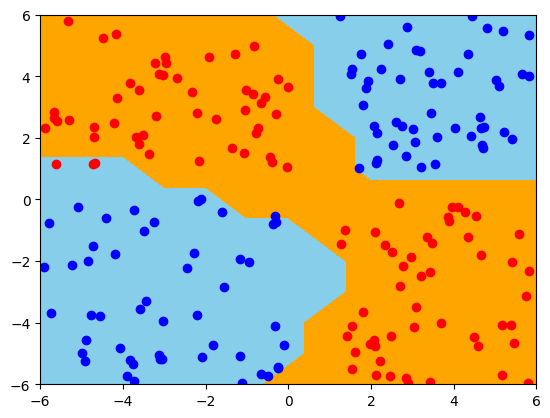

In [11]:
xx = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
# print(xx)
yy = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)
xx, yy = torch.meshgrid(xx, yy)
# print(xx)
xx1 = xx.reshape(-1, 1)
yy1 = yy.reshape(-1, 1)
data = torch.hstack([xx1,yy1])
z = model(data)
z = torch.where(z > 0.5, 1, 0)
z = z.reshape(13,13)
fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red');

### MLP with L1 regularisation



In [12]:
# Define the MLP model
class MLP_L1(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP_L1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()



    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

Epoch 0 Accuracy 0.4938
Epoch 501 Accuracy 0.9750
In 1 Cross-validation, Training loss: 0.2723
Fold 1 - Validation loss: 0.1354, Validation accuracy: 0.9750
Epoch 0 Accuracy 0.5688
Epoch 501 Accuracy 0.8750
In 2 Cross-validation, Training loss: 0.3812
Fold 2 - Validation loss: 0.3583, Validation accuracy: 0.8500
Epoch 0 Accuracy 0.4812
Epoch 501 Accuracy 0.8813
In 3 Cross-validation, Training loss: 0.3722
Fold 3 - Validation loss: 0.3047, Validation accuracy: 0.8250
Epoch 0 Accuracy 0.5312
Epoch 501 Accuracy 0.9500
In 4 Cross-validation, Training loss: 0.2976
Fold 4 - Validation loss: 0.4761, Validation accuracy: 0.8250
Epoch 0 Accuracy 0.4750
Epoch 501 Accuracy 1.0000
In 5 Cross-validation, Training loss: 0.2769
Fold 5 - Validation loss: 0.1241, Validation accuracy: 1.0000

Learning Rate: 0.01, Lagrange Multiplier: 0.001
Average Validation Loss: 0.2797, Average Validation Accuracy: 0.8950

Fold-wise results: {'Fold 1': {'Loss': 0.1353732943534851, 'Accuracy': 0.9750000238418579}, 'Fol

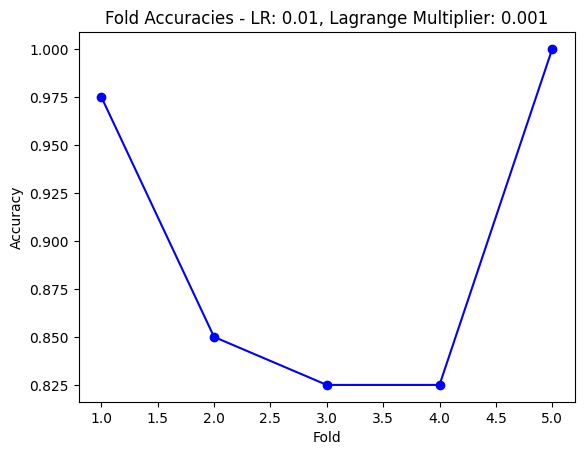

Epoch 0 Accuracy 0.6875
Epoch 501 Accuracy 0.5063
In 1 Cross-validation, Training loss: 0.6950
Fold 1 - Validation loss: 0.6933, Validation accuracy: 0.4750
Epoch 0 Accuracy 0.4688
Epoch 501 Accuracy 0.5063
In 2 Cross-validation, Training loss: 0.6954
Fold 2 - Validation loss: 0.6935, Validation accuracy: 0.4750
Epoch 0 Accuracy 0.4812
Epoch 501 Accuracy 0.5188
In 3 Cross-validation, Training loss: 0.6948
Fold 3 - Validation loss: 0.6964, Validation accuracy: 0.4250
Epoch 0 Accuracy 0.5813
Epoch 501 Accuracy 0.5312
In 4 Cross-validation, Training loss: 0.6944
Fold 4 - Validation loss: 0.7053, Validation accuracy: 0.3750
Epoch 0 Accuracy 0.3625
Epoch 501 Accuracy 0.5250
In 5 Cross-validation, Training loss: 0.6937
Fold 5 - Validation loss: 0.7009, Validation accuracy: 0.4000

Learning Rate: 0.01, Lagrange Multiplier: 0.01
Average Validation Loss: 0.6979, Average Validation Accuracy: 0.4300

Fold-wise results: {'Fold 1': {'Loss': 0.693341076374054, 'Accuracy': 0.4749999940395355}, 'Fold 

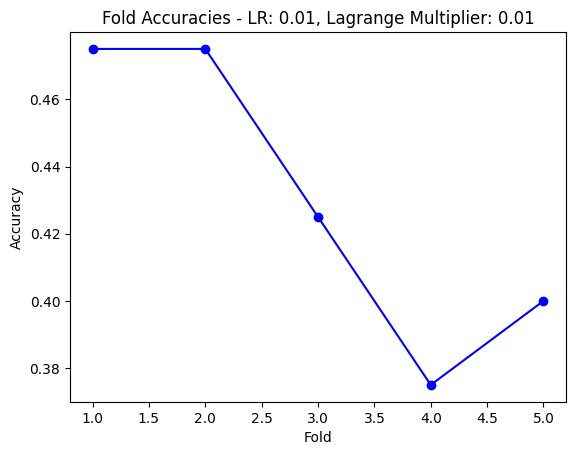

Epoch 0 Accuracy 0.5063
Epoch 501 Accuracy 0.5063
In 1 Cross-validation, Training loss: 0.6980
Fold 1 - Validation loss: 0.6937, Validation accuracy: 0.4750
Epoch 0 Accuracy 0.4938
Epoch 501 Accuracy 0.4938
In 2 Cross-validation, Training loss: 0.6981
Fold 2 - Validation loss: 0.6936, Validation accuracy: 0.5250
Epoch 0 Accuracy 0.4812
Epoch 501 Accuracy 0.5188
In 3 Cross-validation, Training loss: 0.6976
Fold 3 - Validation loss: 0.6939, Validation accuracy: 0.4250
Epoch 0 Accuracy 0.5063
Epoch 501 Accuracy 0.5312
In 4 Cross-validation, Training loss: 0.6980
Fold 4 - Validation loss: 0.6944, Validation accuracy: 0.3750
Epoch 0 Accuracy 0.4750
Epoch 501 Accuracy 0.5250
In 5 Cross-validation, Training loss: 0.6993
Fold 5 - Validation loss: 0.6944, Validation accuracy: 0.4000

Learning Rate: 0.01, Lagrange Multiplier: 0.03
Average Validation Loss: 0.6940, Average Validation Accuracy: 0.4400

Fold-wise results: {'Fold 1': {'Loss': 0.693742036819458, 'Accuracy': 0.4749999940395355}, 'Fold 

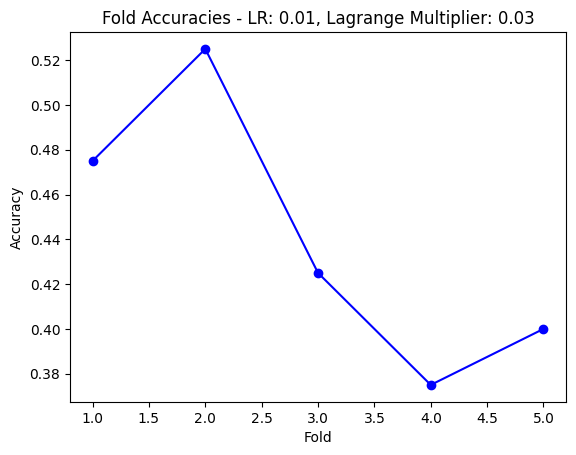

Epoch 0 Accuracy 0.4938
Epoch 501 Accuracy 0.5063
In 1 Cross-validation, Training loss: 0.7073
Fold 1 - Validation loss: 0.6956, Validation accuracy: 0.4750
Epoch 0 Accuracy 0.6125
Epoch 501 Accuracy 0.4938
In 2 Cross-validation, Training loss: 0.7071
Fold 2 - Validation loss: 0.6954, Validation accuracy: 0.5250
Epoch 0 Accuracy 0.5188
Epoch 501 Accuracy 0.5188
In 3 Cross-validation, Training loss: 0.7103
Fold 3 - Validation loss: 0.6960, Validation accuracy: 0.4250
Epoch 0 Accuracy 0.3938
Epoch 501 Accuracy 0.5312
In 4 Cross-validation, Training loss: 0.7037
Fold 4 - Validation loss: 0.6949, Validation accuracy: 0.3750
Epoch 0 Accuracy 0.4375
Epoch 501 Accuracy 0.4750
In 5 Cross-validation, Training loss: 0.7084
Fold 5 - Validation loss: 0.6960, Validation accuracy: 0.4000

Learning Rate: 0.01, Lagrange Multiplier: 0.1
Average Validation Loss: 0.6956, Average Validation Accuracy: 0.4400

Fold-wise results: {'Fold 1': {'Loss': 0.6955541968345642, 'Accuracy': 0.4749999940395355}, 'Fold 

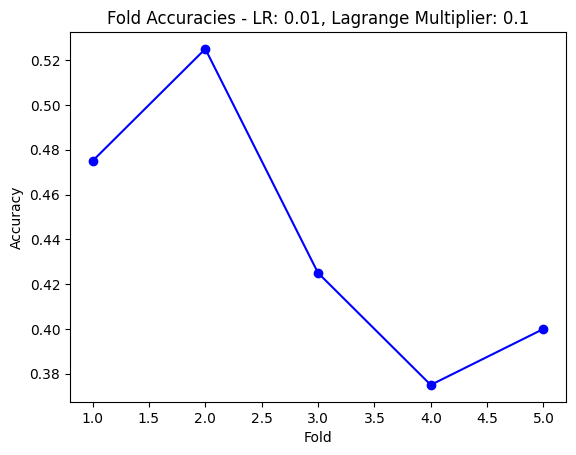

Epoch 0 Accuracy 0.4938
Epoch 501 Accuracy 0.9812
In 1 Cross-validation, Training loss: 0.1571
Fold 1 - Validation loss: 0.1468, Validation accuracy: 0.9750
Epoch 0 Accuracy 0.5063
Epoch 501 Accuracy 1.0000
In 2 Cross-validation, Training loss: 0.1058
Fold 2 - Validation loss: 0.0910, Validation accuracy: 1.0000
Epoch 0 Accuracy 0.5063
Epoch 501 Accuracy 0.9125
In 3 Cross-validation, Training loss: 0.2540
Fold 3 - Validation loss: 0.1762, Validation accuracy: 0.9750
Epoch 0 Accuracy 0.4688
Epoch 501 Accuracy 0.9937
In 4 Cross-validation, Training loss: 0.1346
Fold 4 - Validation loss: 0.1759, Validation accuracy: 0.9500
Epoch 0 Accuracy 0.5250
Epoch 501 Accuracy 1.0000
In 5 Cross-validation, Training loss: 0.1104
Fold 5 - Validation loss: 0.0921, Validation accuracy: 1.0000

Learning Rate: 0.1, Lagrange Multiplier: 0.001
Average Validation Loss: 0.1364, Average Validation Accuracy: 0.9800

Fold-wise results: {'Fold 1': {'Loss': 0.14681029319763184, 'Accuracy': 0.9750000238418579}, 'Fol

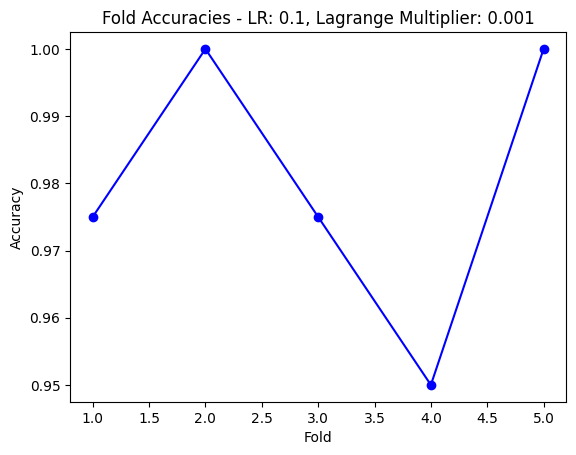

Epoch 0 Accuracy 0.4938
Epoch 501 Accuracy 0.5063
In 1 Cross-validation, Training loss: 0.6954
Fold 1 - Validation loss: 0.6954, Validation accuracy: 0.4750
Epoch 0 Accuracy 0.4938
Epoch 501 Accuracy 0.5063
In 2 Cross-validation, Training loss: 0.6954
Fold 2 - Validation loss: 0.6957, Validation accuracy: 0.4750
Epoch 0 Accuracy 0.3500
Epoch 501 Accuracy 0.5188
In 3 Cross-validation, Training loss: 0.6954
Fold 3 - Validation loss: 0.6994, Validation accuracy: 0.4250
Epoch 0 Accuracy 0.5312
Epoch 501 Accuracy 0.5312
In 4 Cross-validation, Training loss: 0.6944
Fold 4 - Validation loss: 0.7046, Validation accuracy: 0.3750
Epoch 0 Accuracy 0.5250
Epoch 501 Accuracy 0.5250
In 5 Cross-validation, Training loss: 0.6949
Fold 5 - Validation loss: 0.7026, Validation accuracy: 0.4000

Learning Rate: 0.1, Lagrange Multiplier: 0.01
Average Validation Loss: 0.6995, Average Validation Accuracy: 0.4300

Fold-wise results: {'Fold 1': {'Loss': 0.6953946352005005, 'Accuracy': 0.4749999940395355}, 'Fold 

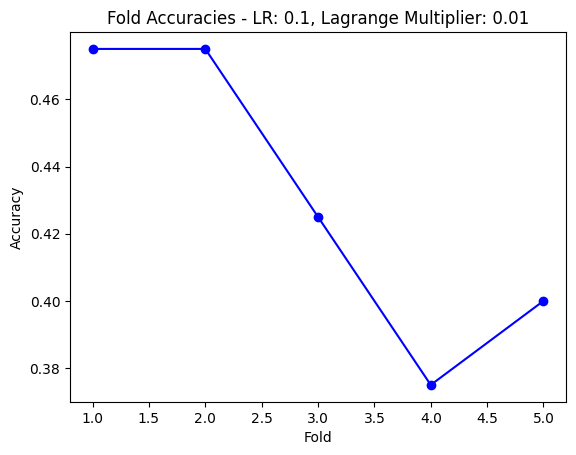

Epoch 0 Accuracy 0.4812
Epoch 501 Accuracy 0.5063
In 1 Cross-validation, Training loss: 0.7000
Fold 1 - Validation loss: 0.6982, Validation accuracy: 0.4750
Epoch 0 Accuracy 0.4938
Epoch 501 Accuracy 0.5063
In 2 Cross-validation, Training loss: 0.6999
Fold 2 - Validation loss: 0.6983, Validation accuracy: 0.5250
Epoch 0 Accuracy 0.5188
Epoch 501 Accuracy 0.5188
In 3 Cross-validation, Training loss: 0.6999
Fold 3 - Validation loss: 0.7021, Validation accuracy: 0.4250
Epoch 0 Accuracy 0.5750
Epoch 501 Accuracy 0.5312
In 4 Cross-validation, Training loss: 0.6993
Fold 4 - Validation loss: 0.7047, Validation accuracy: 0.3750
Epoch 0 Accuracy 0.6313
Epoch 501 Accuracy 0.5250
In 5 Cross-validation, Training loss: 0.7000
Fold 5 - Validation loss: 0.7033, Validation accuracy: 0.4000

Learning Rate: 0.1, Lagrange Multiplier: 0.03
Average Validation Loss: 0.7013, Average Validation Accuracy: 0.4400

Fold-wise results: {'Fold 1': {'Loss': 0.6981799602508545, 'Accuracy': 0.4749999940395355}, 'Fold 

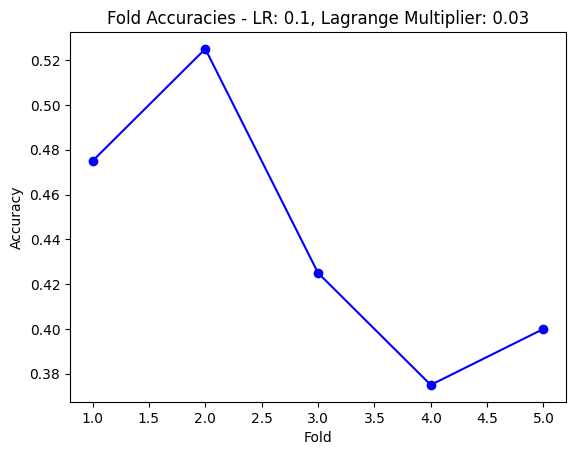

Epoch 0 Accuracy 0.4062
Epoch 501 Accuracy 0.5063
In 1 Cross-validation, Training loss: 0.7183
Fold 1 - Validation loss: 0.7137, Validation accuracy: 0.4750
Epoch 0 Accuracy 0.3938
Epoch 501 Accuracy 0.4938
In 2 Cross-validation, Training loss: 0.7162
Fold 2 - Validation loss: 0.7139, Validation accuracy: 0.5250
Epoch 0 Accuracy 0.7312
Epoch 501 Accuracy 0.4812
In 3 Cross-validation, Training loss: 0.7160
Fold 3 - Validation loss: 0.7108, Validation accuracy: 0.4250
Epoch 0 Accuracy 0.5625
Epoch 501 Accuracy 0.4688
In 4 Cross-validation, Training loss: 0.7142
Fold 4 - Validation loss: 0.7094, Validation accuracy: 0.6250
Epoch 0 Accuracy 0.4750
Epoch 501 Accuracy 0.4750
In 5 Cross-validation, Training loss: 0.7164
Fold 5 - Validation loss: 0.7157, Validation accuracy: 0.6000

Learning Rate: 0.1, Lagrange Multiplier: 0.1
Average Validation Loss: 0.7127, Average Validation Accuracy: 0.5300

Fold-wise results: {'Fold 1': {'Loss': 0.7137004733085632, 'Accuracy': 0.4749999940395355}, 'Fold 2

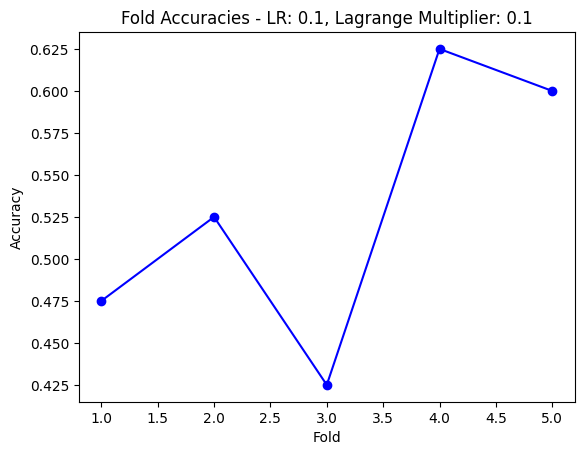

Epoch 0 Accuracy 0.5875
Epoch 501 Accuracy 1.0000
In 1 Cross-validation, Training loss: 0.1526
Fold 1 - Validation loss: 0.0955, Validation accuracy: 1.0000
Epoch 0 Accuracy 0.4563
Epoch 501 Accuracy 0.9875
In 2 Cross-validation, Training loss: 0.2166
Fold 2 - Validation loss: 0.3211, Validation accuracy: 0.9500
Epoch 0 Accuracy 0.5188
Epoch 501 Accuracy 0.9812
In 3 Cross-validation, Training loss: 0.2078
Fold 3 - Validation loss: 0.1603, Validation accuracy: 0.9750
Epoch 0 Accuracy 0.4688
Epoch 501 Accuracy 1.0000
In 4 Cross-validation, Training loss: 0.1750
Fold 4 - Validation loss: 0.3795, Validation accuracy: 0.9000
Epoch 0 Accuracy 0.4750
Epoch 501 Accuracy 0.9563
In 5 Cross-validation, Training loss: 0.2465
Fold 5 - Validation loss: 0.2015, Validation accuracy: 0.9750

Learning Rate: 1, Lagrange Multiplier: 0.001
Average Validation Loss: 0.2316, Average Validation Accuracy: 0.9600

Fold-wise results: {'Fold 1': {'Loss': 0.09550739824771881, 'Accuracy': 1.0}, 'Fold 2': {'Loss': 0.

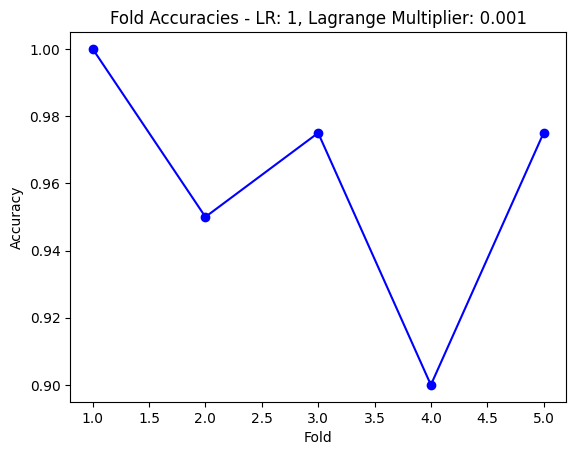

Epoch 0 Accuracy 0.5063
Epoch 501 Accuracy 0.8750
In 1 Cross-validation, Training loss: 0.5523
Fold 1 - Validation loss: 0.4376, Validation accuracy: 0.9250
Epoch 0 Accuracy 0.4750
Epoch 501 Accuracy 1.0000
In 2 Cross-validation, Training loss: 0.5054
Fold 2 - Validation loss: 0.4864, Validation accuracy: 1.0000
Epoch 0 Accuracy 0.5188
Epoch 501 Accuracy 1.0000
In 3 Cross-validation, Training loss: 0.4965
Fold 3 - Validation loss: 0.5014, Validation accuracy: 1.0000
Epoch 0 Accuracy 0.5375
Epoch 501 Accuracy 1.0000
In 4 Cross-validation, Training loss: 0.4893
Fold 4 - Validation loss: 0.5604, Validation accuracy: 0.9750
Epoch 0 Accuracy 0.5312
Epoch 501 Accuracy 0.8687
In 5 Cross-validation, Training loss: 0.5204
Fold 5 - Validation loss: 0.5543, Validation accuracy: 0.8750

Learning Rate: 1, Lagrange Multiplier: 0.01
Average Validation Loss: 0.5080, Average Validation Accuracy: 0.9550

Fold-wise results: {'Fold 1': {'Loss': 0.4375936985015869, 'Accuracy': 0.925000011920929}, 'Fold 2':

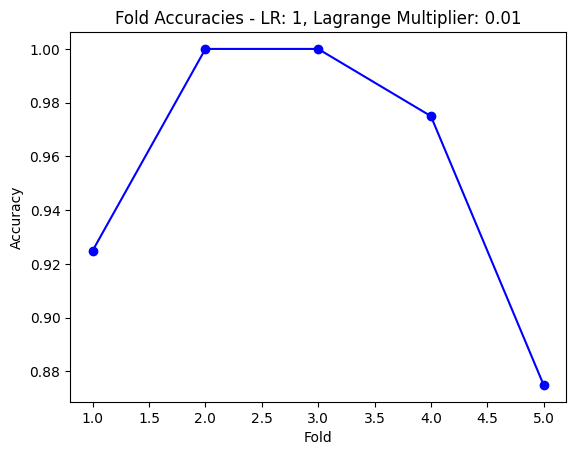

Epoch 0 Accuracy 0.4938
Epoch 501 Accuracy 0.5063
In 1 Cross-validation, Training loss: 0.7538
Fold 1 - Validation loss: 0.7648, Validation accuracy: 0.5250
Epoch 0 Accuracy 0.5063
Epoch 501 Accuracy 0.5063
In 2 Cross-validation, Training loss: 0.7556
Fold 2 - Validation loss: 0.7460, Validation accuracy: 0.4750
Epoch 0 Accuracy 0.5188
Epoch 501 Accuracy 0.4875
In 3 Cross-validation, Training loss: 0.7540
Fold 3 - Validation loss: 0.7585, Validation accuracy: 0.4000
Epoch 0 Accuracy 0.4688
Epoch 501 Accuracy 0.4688
In 4 Cross-validation, Training loss: 0.7520
Fold 4 - Validation loss: 0.7676, Validation accuracy: 0.3750
Epoch 0 Accuracy 0.5250
Epoch 501 Accuracy 0.5250
In 5 Cross-validation, Training loss: 0.7563
Fold 5 - Validation loss: 0.7499, Validation accuracy: 0.4750

Learning Rate: 1, Lagrange Multiplier: 0.03
Average Validation Loss: 0.7574, Average Validation Accuracy: 0.4500

Fold-wise results: {'Fold 1': {'Loss': 0.7647871971130371, 'Accuracy': 0.5249999761581421}, 'Fold 2'

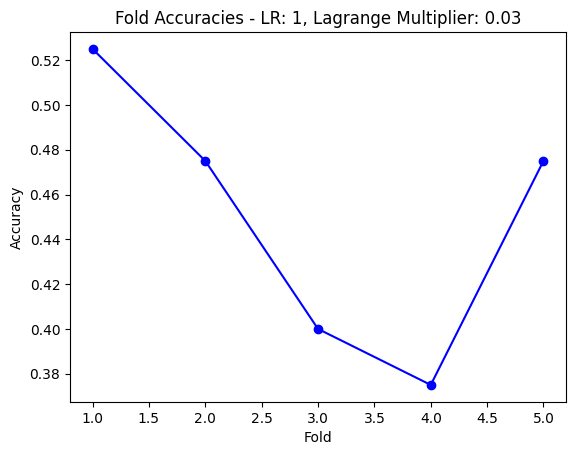

Epoch 0 Accuracy 0.4688
Epoch 501 Accuracy 0.5063
In 1 Cross-validation, Training loss: 0.8933
Fold 1 - Validation loss: 0.8573, Validation accuracy: 0.5250
Epoch 0 Accuracy 0.5063
Epoch 501 Accuracy 0.4938
In 2 Cross-validation, Training loss: 0.8896
Fold 2 - Validation loss: 0.8524, Validation accuracy: 0.5250
Epoch 0 Accuracy 0.4812
Epoch 501 Accuracy 0.5188
In 3 Cross-validation, Training loss: 0.8974
Fold 3 - Validation loss: 0.8851, Validation accuracy: 0.7000
Epoch 0 Accuracy 0.5312
Epoch 501 Accuracy 0.4625
In 4 Cross-validation, Training loss: 0.8868
Fold 4 - Validation loss: 0.8415, Validation accuracy: 0.6750
Epoch 0 Accuracy 0.5250
Epoch 501 Accuracy 0.5250
In 5 Cross-validation, Training loss: 0.8990
Fold 5 - Validation loss: 0.9482, Validation accuracy: 0.4000

Learning Rate: 1, Lagrange Multiplier: 0.1
Average Validation Loss: 0.8769, Average Validation Accuracy: 0.5650

Fold-wise results: {'Fold 1': {'Loss': 0.8573261499404907, 'Accuracy': 0.5249999761581421}, 'Fold 2':

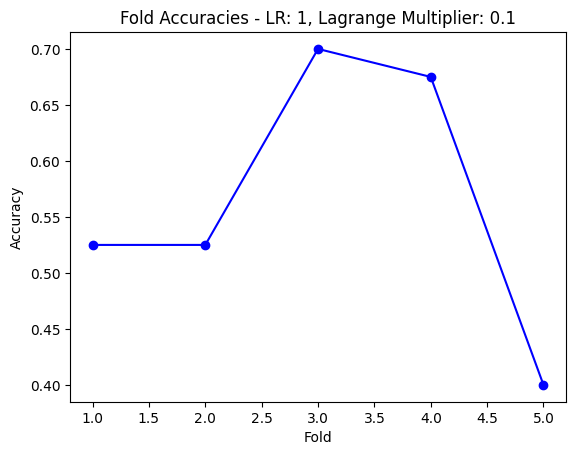

In [13]:
# 5-fold cross validation
K = 5
epochs = 1000
block = len(train_data) // K
valid_loss_acc = {}

for learning_rate in [ 0.01, 0.1, 1]:
    for lagrange_multiplier in [0.001, 0.01, 0.03, 0.1]:
        k_cross_val_loss = []
        k_cross_val_acc = []
        fold_accuracies = []
        fold_results = {}  # to store each fold's results
        
        for i in range(K):
            start = i * block
            end = start + block
            val_dataset = train_data[start:end].reset_index(drop=True)
            X_val = val_dataset[['x1', 'x2']].values.astype(np.float32)
            y_val = val_dataset['y'].values.reshape(-1, 1).astype(np.float32)
            val_dataset = CustomDataset(X_val, y_val)
            val_loader = DataLoader(val_dataset, batch_size=40, shuffle=True)

            Xy_train = pd.concat([train_data[:start], train_data[end:]], axis=0).reset_index(drop=True)
            X_train = Xy_train[['x1', 'x2']].values.astype(np.float32)
            y_train = Xy_train['y'].values.reshape(-1, 1).astype(np.float32)
            train_dataset = CustomDataset(X_train, y_train)
            train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)

            # Initialise MLP
            model = MLP_L1(input_size=2, hidden_size=4)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Training the model
            train_losses = []
            for epoch in range(epochs):
                train_loss = 0.0
                accuracy = 0
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    output_labels = torch.where(outputs >= 0.5, 1.0, 0.0)
                    accuracy += torch.sum(output_labels == labels)
                    loss = criterion(outputs, labels)

                    # L1 regularization
                    l1_sum = sum(torch.sum(abs(param)) for param in model.parameters())
                    loss += lagrange_multiplier * l1_sum
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()

                if epoch % 501 == 0:
                    print(f'Epoch {epoch} Accuracy {accuracy / len(train_loader.dataset):.4f}')

                train_loss /= len(train_loader)
                train_losses.append(train_loss)

            total_train_loss = np.mean(train_losses)
            print(f'In {i + 1} Cross-validation, Training loss: {total_train_loss:.4f}')

            # Validation
            val_loss = 0.0
            accuracy = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    output_labels = torch.where(outputs >= 0.5, 1.0, 0.0)
                    accuracy += torch.sum(output_labels == labels)

                    loss = criterion(outputs, labels)
                    # L1 regularization
                    l1_sum = sum(torch.sum(abs(param)) for param in model.parameters())
                    loss += lagrange_multiplier * l1_sum

                    val_loss += loss.item()

            fold_accuracy = accuracy / len(val_dataset)
            fold_loss = val_loss / len(val_loader)
            k_cross_val_loss.append(fold_loss)
            k_cross_val_acc.append(fold_accuracy)
            fold_accuracies.append(fold_accuracy.item())

            print(f'Fold {i + 1} - Validation loss: {fold_loss:.4f}, Validation accuracy: {fold_accuracy:.4f}')

            # Store fold-specific results
            fold_results[f'Fold {i + 1}'] = {'Loss': fold_loss, 'Accuracy': fold_accuracy.item()}

        # Store and print average results for the current combination
        avg_loss = np.mean(k_cross_val_loss)
        avg_acc = np.mean(k_cross_val_acc)
        valid_loss_acc[f'{learning_rate}_{lagrange_multiplier}'] = {
            'Avg Loss': avg_loss,
            'Avg Accuracy': avg_acc,
            'Folds': fold_results
        }

        print(f'\nLearning Rate: {learning_rate}, Lagrange Multiplier: {lagrange_multiplier}')
        print(f'Average Validation Loss: {avg_loss:.4f}, Average Validation Accuracy: {avg_acc:.4f}\n')
        print(f'Fold-wise results: {fold_results}\n')

        # Plotting fold accuracies for current hyperparameter combination
        plt.figure()
        plt.plot(range(1, K + 1), fold_accuracies, marker='o', linestyle='-', color='b')
        plt.title(f'Fold Accuracies - LR: {learning_rate}, Lagrange Multiplier: {lagrange_multiplier}')
        plt.xlabel('Fold')
        plt.ylabel('Accuracy')
        plt.show()


In [17]:
# Find the best combination of learning rate and Lagrange multiplier
best_params = None
best_accuracy = 0

for params, results in valid_loss_acc.items():
    avg_accuracy = results['Avg Accuracy']
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_params = params

# Print the best parameters and accuracy
best_lr, best_lagrange = best_params.split('_')
print(f"Best Learning Rate: {best_lr}")
print(f"Best Lagrange Multiplier: {best_lagrange}")
print(f"Best Cross-Validation Accuracy: {best_accuracy:.4f}")


Best Learning Rate: 0.1
Best Lagrange Multiplier: 0.001
Best Cross-Validation Accuracy: 0.9800


In [18]:
model = MLP_L1(input_size=2, hidden_size=4)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
lagrange_multiplier = 0.001

# training the model
for epoch in range(epochs): #No of epochs 1000
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        sum = 0
        for params in model.parameters():
            params = params.view(-1)
            sum += torch.sum(abs(params))

        loss += lagrange_multiplier * sum
        loss.backward()
        optimizer.step()

In [19]:
X_test = test_data[['x1', 'x2']].values.astype(np.float32)
y_test = test_data['y1'].values.reshape(-1, 1).astype(np.float32)
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)

test_loss = 0.0
accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        # print(torch.hstack([inputs, outputs, output_labels, labels]))
        accuracy += torch.sum(output_labels == labels)
        loss = criterion(outputs, labels)
        # test_loss += loss.item() * inputs.size(0)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test loss: {test_loss:.4f}, accuracy: {accuracy/len(test_loader.dataset):.4f}')

Test loss: 0.2520, accuracy: 0.9150


/tmp/ipykernel_940516/1642735607.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx1 = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
/tmp/ipykernel_940516/1642735607.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx2 = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)


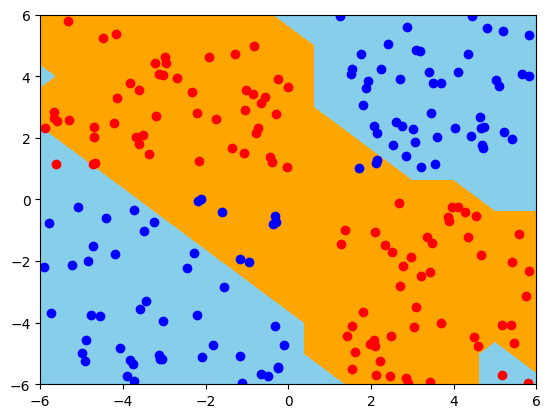

In [20]:
xx1 = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
xx2 = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)
xx1, xx2 = torch.meshgrid(xx1, xx2)
xx1 = xx1.reshape(-1, 1)
xx2 = xx2.reshape(-1, 1)
data = torch.hstack([xx1,xx2])
z = model(data)
z = torch.where(z > 0.5, 1, 0)
z = z.reshape(13,13)

fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red')

### MLP with L2 Regularisation



In [21]:
# Define the MLP model
class MLP_L2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP_L2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()



    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [24]:
# 5-fold cross validation
K = 5
epochs = 1000
block = len(train_data) // K
valid_loss_acc = {}

for learning_rate in [ 0.01, 0.1, 1]:
    for lagrange_multiplier in [0.001, 0.01, 0.03, 0.1]:
        k_cross_val_loss = []
        k_cross_val_acc = []
        for i in range(K):
            start = i * block
            end = start + block
            val_dataset = train_data[start : end].reset_index(drop = True)
            X_val = val_dataset[['x1', 'x2']].values.astype(np.float32)
            y_val = val_dataset['y'].values.reshape(-1, 1).astype(np.float32)
            val_dataset = CustomDataset(X_val, y_val)
            val_loader = DataLoader(val_dataset, batch_size=40, shuffle=True)

            Xy_train = pd.concat([train_data[ : start], train_data[end : ]], axis = 0).reset_index(drop = True)
            X_train = Xy_train[['x1', 'x2']].values.astype(np.float32)
            y_train = Xy_train['y'].values.reshape(-1, 1).astype(np.float32)
            train_dataset = CustomDataset(X_train, y_train)
            train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)

            # initialise MLP
            model = MLP_L2(input_size=2, hidden_size=4)
            criterion = nn.BCELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # training the model
            train_losses = []
            for epoch in range(epochs):
                train_loss = 0.0
                accuracy = 0
                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
                    accuracy += torch.sum(output_labels == labels)
                    loss = criterion(outputs, labels)

                    sum = 0
                    for params in model.parameters():
                        params = params.view(-1)
                        params = torch.square(params)
                        sum += torch.sum(params)

                    loss += lagrange_multiplier * sum
                    loss.backward()
                    optimizer.step()
                    train_loss += loss.item()

                if epoch % 501 == 0:
                    print(f'Epoch {epoch} Accuracy {accuracy/len(train_loader.dataset):.4f}')

                train_loss /= len(train_loader)
                train_losses.append(train_loss)

            # print(torch.hstack([inputs, outputs, output_labels, labels]))
            total_train_loss = np.mean(train_losses)
            print(f'In {i+1} Cross validation, Training loss: {total_train_loss:.4f}')


            # validate
            val_loss = 0.0
            accuracy = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
                    # print(torch.hstack([inputs, outputs, output_labels, labels]))
                    accuracy += torch.sum(output_labels == labels)

                    loss = criterion(outputs, labels)
                    for params in model.parameters():
                        params = params.view(-1)
                        params = torch.square(params)
                        sum += torch.sum(params)
                    loss += lagrange_multiplier * sum

                    val_loss += loss.item()

            k_cross_val_loss.append(val_loss/len(val_loader))
            k_cross_val_acc.append(accuracy/len(val_dataset))
            print(f'Validation loss: {val_loss/len(val_loader):.4f}, Validation accuracy: {accuracy/len(val_dataset):.4f}')

        valid_loss_acc[f'{learning_rate}_{lagrange_multiplier}_loss'] = np.mean(k_cross_val_loss)
        valid_loss_acc[f'{learning_rate}_{lagrange_multiplier}_acc'] = np.mean(k_cross_val_acc)

Epoch 0 Accuracy 0.4938
Epoch 501 Accuracy 0.9250
In 1 Cross validation, Training loss: 0.3787
Validation loss: 0.4034, Validation accuracy: 0.9500
Epoch 0 Accuracy 0.5063
Epoch 501 Accuracy 0.9875
In 2 Cross validation, Training loss: 0.3134
Validation loss: 0.4277, Validation accuracy: 0.9750
Epoch 0 Accuracy 0.5750
Epoch 501 Accuracy 0.9688
In 3 Cross validation, Training loss: 0.3202
Validation loss: 0.4497, Validation accuracy: 1.0000
Epoch 0 Accuracy 0.5312
Epoch 501 Accuracy 0.8875
In 4 Cross validation, Training loss: 0.3360
Validation loss: 0.5674, Validation accuracy: 0.8000
Epoch 0 Accuracy 0.4750
Epoch 501 Accuracy 0.9688
In 5 Cross validation, Training loss: 0.3157
Validation loss: 0.4415, Validation accuracy: 0.9500
Epoch 0 Accuracy 0.3438
Epoch 501 Accuracy 0.9625
In 1 Cross validation, Training loss: 0.4715
Validation loss: 0.6401, Validation accuracy: 0.9250
Epoch 0 Accuracy 0.6125
Epoch 501 Accuracy 0.9500
In 2 Cross validation, Training loss: 0.4810
Validation loss: 

In [25]:
# Find the best learning rate and Lagrange multiplier based on validation accuracy
best_params = None
best_accuracy = 0

# Iterate through the dictionary to find the best accuracy
for params in valid_loss_acc.keys():
    # Only consider accuracy keys
    if '_acc' in params:
        current_accuracy = valid_loss_acc[params]
        if current_accuracy > best_accuracy:
            best_accuracy = current_accuracy
            best_params = params

# Extract learning rate and lagrange multiplier from the best parameter string
best_learning_rate, best_lagrange_multiplier = best_params.replace('_acc', '').split('_')
print(f"Best Learning Rate: {best_learning_rate}")
print(f"Best Lagrange Multiplier: {best_lagrange_multiplier}")
print(f"Best Cross-Validation Accuracy: {best_accuracy:.4f}")


Best Learning Rate: 0.03
Best Lagrange Multiplier: 0.001
Best Cross-Validation Accuracy: 0.9350


In [26]:
model = MLP_L2(input_size=2, hidden_size=4)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.03)
lagrange_multiplier = 0.001

# training the model
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        sum = 0
        for params in model.parameters():
            params = params.view(-1)
            params = torch.square(params)
            sum += torch.sum(params)

        loss += lagrange_multiplier * sum
        loss.backward()
        optimizer.step()

In [27]:
X_test = test_data[['x1', 'x2']].values.astype(np.float32)
y_test = test_data['y1'].values.reshape(-1, 1).astype(np.float32)
test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=True)

test_loss = 0.0
accuracy = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        output_labels = torch.where(outputs >= 0.5 , 1.0, 0.0)
        # print(torch.hstack([inputs, outputs, output_labels, labels]))
        accuracy += torch.sum(output_labels == labels)
        loss = criterion(outputs, labels)
        # test_loss += loss.item() * inputs.size(0)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f'Test loss: {test_loss:.4f}, accuracy: {accuracy/len(test_loader.dataset):.4f}')

Test loss: 0.1838, accuracy: 0.9650


/tmp/ipykernel_940516/1642735607.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx1 = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
/tmp/ipykernel_940516/1642735607.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx2 = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)


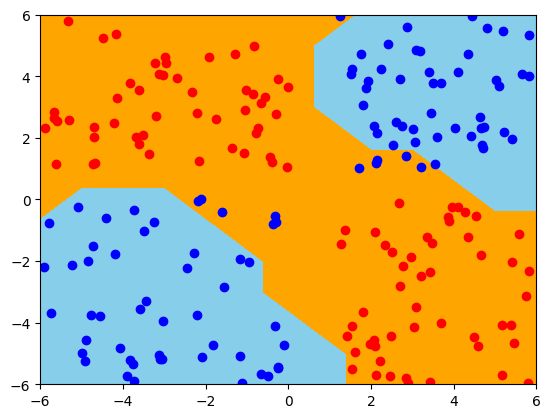

In [28]:
xx1 = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
xx2 = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)
xx1, xx2 = torch.meshgrid(xx1, xx2)
xx1 = xx1.reshape(-1, 1)
xx2 = xx2.reshape(-1, 1)
data = torch.hstack([xx1,xx2])
z = model(data)
z = torch.where(z > 0.5, 1, 0)
z = z.reshape(13,13)

fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red')

### Logistic Regression Model



In [29]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        logits = self.linear(x)
        return logits

In [30]:
# Shuffle train and test data
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [31]:
X_train = pd.concat([train_data['x1'], train_data['x2'], train_data['x1']**2], axis = 1)
X_train.columns = ['x1','x2','x1^2']
X_train = torch.tensor(X_train.values, dtype= torch.float32)
y_train = train_data['y']
y_train = torch.tensor(y_train.values, dtype= torch.float32)

In [32]:
reg = LogisticRegression(3)
opt = torch.optim.Adam(reg.parameters(), lr=0.01)
converged = False

prev_loss = 1e8

i = 0
while not converged:
    opt.zero_grad()
    logits = reg(X_train)
    logits = logits.reshape(-1)
    # print(logits)
    loss = F.binary_cross_entropy_with_logits(logits, y_train)
    loss.backward()
    opt.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item()
    i = i + 1


pred = F.sigmoid(reg(X_train))
pred = torch.where(pred > 0.5 , 1.0, 0.0)
y_train = y_train.reshape(-1, 1)
correct_pred = torch.sum(pred == y_train)
acc = correct_pred / len(y_train)
print(f'Accurcay of Logistic regression using features x1, x2 and square of x1 is {acc}')

0 1.4169795513153076
10 0.9896347522735596
20 0.8608561754226685
30 0.7668032050132751
40 0.7220790386199951
50 0.7035582065582275
60 0.7015809416770935
70 0.6998012661933899
80 0.6976261734962463
90 0.6961418390274048
100 0.6951988935470581
110 0.6945084929466248
120 0.6939923763275146
130 0.6936282515525818
140 0.693378746509552
150 0.6932095885276794
Accurcay of Logistic regression using features x1, x2 and square of x1 is 0.5099999904632568


In [33]:
X_train = pd.concat([train_data['x1'], train_data['x2'], train_data['x1']*train_data['x2']], axis = 1)
X_train.columns = ['x1','x2','x1x2']
X_train = torch.tensor(X_train.values, dtype= torch.float32)
y_train = train_data['y']
y_train = torch.tensor(y_train.values, dtype= torch.float32)

reg = LogisticRegression(3)
opt = torch.optim.Adam(reg.parameters(), lr=0.01)
converged = False

prev_loss = 1e8

i = 0
while not converged:
    opt.zero_grad()
    logits = reg(X_train)
    logits = logits.reshape(-1)
    loss = F.binary_cross_entropy_with_logits(logits, y_train)
    loss.backward()
    opt.step()
    if i%250==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item()
    i = i + 1

0 1.6989834308624268
250 0.0739748552441597
500 0.04590018093585968
750 0.0336156040430069
1000 0.02644881047308445
1250 0.021656835451722145
1500 0.018181823194026947


In [34]:
pred = F.sigmoid(reg(X_train))
pred = torch.where(pred > 0.5 , 1.0, 0.0)
y_train = y_train.reshape(-1, 1)
correct_pred = torch.sum(pred == y_train)
acc = correct_pred / len(y_train)
print(f'Training accuracy using Logistic Regression {acc}')

Training accuracy using Logistic Regression 1.0


In [35]:
X_test = pd.concat([test_data['x1'], test_data['x2'], test_data['x1']*test_data['x2']], axis = 1)
X_test.columns = ['x1','x2','x1x2']
X_test = torch.tensor(X_test.values, dtype= torch.float32)
y_test = test_data['y1']
y_test = torch.tensor(y_test.values, dtype= torch.float32)


pred = F.sigmoid(reg(X_test))
pred = torch.where(pred > 0.5 , 1.0, 0.0)
y_test = y_test.reshape(-1, 1)
correct_pred = torch.sum(pred == y_test)
acc = correct_pred / len(y_test)
print(f'Testing accuracy using Logistic Regression {acc}')

Testing accuracy using Logistic Regression 1.0


/tmp/ipykernel_940516/2707420995.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx1 = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
/tmp/ipykernel_940516/2707420995.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx2 = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)


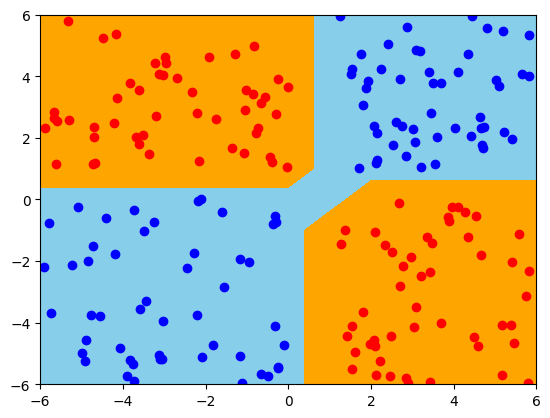

In [36]:
xx1 = torch.tensor(torch.arange(-6.0,7.0), requires_grad = False)
xx2 = torch.tensor(torch.arange(-6.0, 7.0), requires_grad = False)
xx1, xx2 = torch.meshgrid(xx1, xx2)
xx1 = xx1.reshape(-1, 1)
xx2 = xx2.reshape(-1, 1)
xx3 = xx1 * xx2
# print(xx3)
data = torch.hstack([xx1, xx2, xx3 ])
z = reg(data)
z = torch.where(z > 0.5, 1, 0)
z = z.reshape(13,13)

fig = plt.figure()
ax = plt.axes()
ax.contourf(xx, yy, z, colors = ['skyblue', 'orange', 'orange', 'skyblue'], levels = 2)
ax.scatter(test_data['x1'][test_data['y1']==0], test_data['x2'][test_data['y1']==0], color = 'blue')
ax.scatter(test_data['x1'][test_data['y1']==1], test_data['x2'][test_data['y1']==1], color = 'red')